In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
data = pd.read_csv('../data/data_01.txt', sep = '\t')

In [3]:
print(data.shape)
data.head()

(775466, 3)


,fecha,idTerminal,oper
0,2017-01-31 08:19:33.000,1828,0
1,2017-01-31 08:47:16.000,1828,1
2,2017-01-31 08:48:07.000,1828,1
3,2017-01-31 08:48:58.000,1828,1
4,2017-01-31 08:49:53.000,1828,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775466 entries, 0 to 775465
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   fecha       775466 non-null  object
 1   idTerminal  775466 non-null  int64 
 2   oper        775466 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 17.7+ MB


In [5]:
weekDays = ("Lun", "Mar", "Mie", "Jue", "Vie", "Sab", "Dom")

data['dia'] = data['fecha'].str[:10]
data['mes'] = data['dia'].str[:7]

data['dia'] = pd.to_datetime(data['dia'])
data['nombre_dia'] = data['dia'].apply(lambda x: weekDays[x.weekday()])
data['weekend'] = np.where(data['nombre_dia'].isin(['Sab', 'Dom']), 1, 0)

### Serie del total de trx diarias

In [6]:
data_diaria = data.groupby(['dia', 'mes', 'nombre_dia', 'weekend']).size()
data_diaria = pd.DataFrame(data_diaria)
data_diaria.columns = ['num_trx']
data_diaria = data_diaria.reset_index()

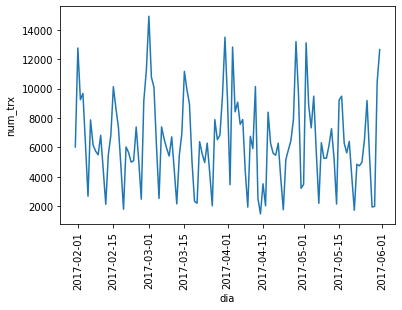

In [7]:
sns.lineplot(x = 'dia', y = 'num_trx', data = data_diaria)
_ = plt.xticks(rotation = 90)

### Análisis de las operaciones y terminales

In [8]:
total_oper = len(data['oper'].unique())
total_term = len(data['idTerminal'].unique())

print('Total de tipos de operaciones diferentes:', total_oper)
print('Total de terminales diferentes:', total_term)

Total de tipos de operaciones diferentes: 46
Total de terminales diferentes: 47


In [9]:
oper_term = data[['oper', 'idTerminal']] \
            .drop_duplicates() \
            .groupby(['oper']) \
            .size()
oper_term = pd.DataFrame(oper_term)
oper_term.columns = ['num_terminales']

<AxesSubplot:ylabel='Frequency'>

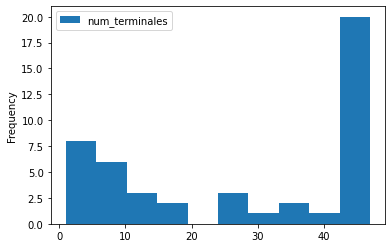

In [10]:
oper_term.plot(kind = 'hist')

In [11]:
ix_oper_muchos_terminales = oper_term[oper_term['num_terminales'] == total_term].index
print('Hay {} operaciones que utilizan los {} terminales'.format(len(ix_oper_muchos_terminales), total_term))

Hay 15 operaciones que utilizan los 47 terminales


In [12]:
share = data[data['oper'].isin(ix_oper_muchos_terminales)].shape[0] / data.shape[0]
share = round(share * 100, 2)
print('Estas {} operaciones tienen el {}% de las trx de los ultimos 4 meses'.format(len(ix_oper_muchos_terminales), share))

Estas 15 operaciones tienen el 98.62% de las trx de los ultimos 4 meses


In [13]:
trx_oper_acum = data['oper'] \
                .value_counts(normalize = True) \
                .cumsum()

# Tomemos el top 5 de operaciones
top_oper    = trx_oper_acum[:5]
ix_top_oper = list(top_oper.index)
share = top_oper.iloc[-1]
share = round(share * 100, 2)

print('El Top 5 de operaciones son: {}'.format(ix_top_oper))
print('Las cuales tienen el {}% de las trx de los ultimos 4 meses'.format(share))
print('Las {} operaciones utilizan todos los terminales'.format(pd.Series(ix_top_oper).isin(ix_oper_muchos_terminales).sum()))

El Top 5 de operaciones son: [0, 3, 1, 7, 4]
Las cuales tienen el 92.46% de las trx de los ultimos 4 meses
Las 5 operaciones utilizan todos los terminales


Para este MVP, asumamos que la entidad bancaria se encuentra interesada en anticipar el volumen de transacciones de estas 5 operaciones, pues la mayoria de sus transacciones (92.4%) se encuentran concentradas aqui.

### Análisis del número de trx y el share de cada operacion

In [76]:
data_oper_top = data[data['oper'].isin(ix_top_oper)]
data_oper_top = data_oper_top.groupby(['dia', 'weekend', 'oper']).size()
data_oper_top = pd.DataFrame(data_oper_top)
data_oper_top.columns = ['num_trx']
data_oper_top = data_oper_top.reset_index()

data_top = data_oper_top.pivot(index = 'dia',
                          columns = 'oper',
                          values = 'num_trx')

data_top.columns = ['oper_' + str(x) for x in data_top.columns]

In [77]:
print(data_diaria.shape)
print(data_top.shape)

(121, 9)
(121, 5)


In [16]:
# Join entre el total de trx y el # de trx por oper
# del top de operaciones para calcular el share
data_diaria = data_diaria \
              .set_index('dia') \
              .join(data_top)

for x in data_top.columns:
    data_diaria[x] = data_diaria[x] / data_diaria['num_trx']

In [17]:
data_diaria.head()

,mes,nombre_dia,weekend,num_trx,oper_0,oper_1,oper_3,oper_4,oper_7
dia,,,,,,,,,
2017-01-31,2017-01,Mar,0,6028,0.552256,0.116125,0.179827,0.066357,0.030856
2017-02-01,2017-02,Mie,0,12760,0.575784,0.081113,0.173354,0.063088,0.033229
2017-02-02,2017-02,Jue,0,9246,0.577439,0.086957,0.155310,0.050508,0.046939
2017-02-03,2017-02,Vie,0,9667,0.550119,0.099824,0.162925,0.047171,0.056481
2017-02-04,2017-02,Sab,1,6212,0.524630,0.121861,0.174340,0.044591,0.064713


<AxesSubplot:xlabel='dia'>

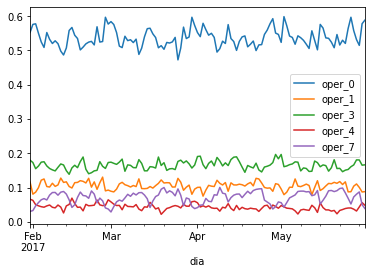

In [19]:
data_diaria \
.drop(columns = ['num_trx', 'weekend']) \
.plot()

<AxesSubplot:xlabel='dia'>

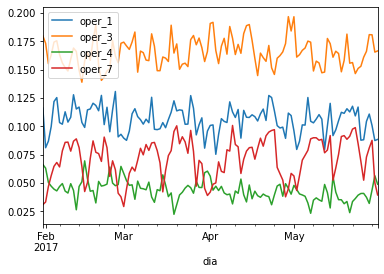

In [20]:
data_diaria \
.drop(columns = ['num_trx', 'weekend', 'oper_0']) \
.plot()

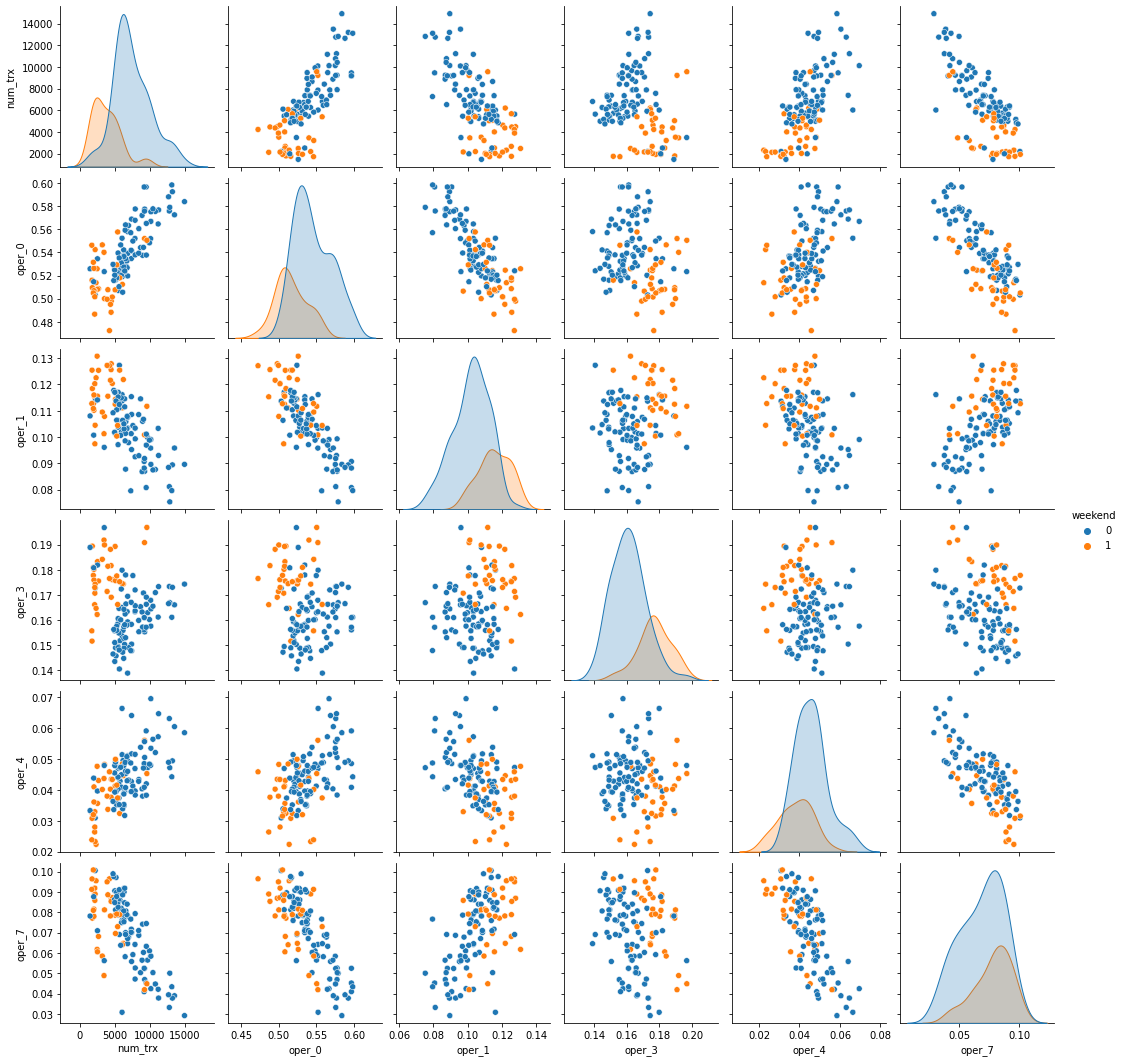

In [23]:
sns.pairplot(data_diaria, hue = 'weekend')

In [22]:
data_diaria.groupby(['nombre_dia']).mean().loc[weekDays, :]

,num_trx,oper_0,oper_1,oper_3,oper_4,oper_7
nombre_dia,,,,,,
Lun,6499.882353,0.538498,0.103017,0.161398,0.044706,0.073196
Mar,7322.166667,0.547884,0.103002,0.158994,0.046605,0.068024
Mie,8190.000000,0.547373,0.101359,0.161913,0.047632,0.064788
Jue,6947.294118,0.544673,0.102242,0.160132,0.044240,0.068811
Vie,8115.941176,0.547310,0.100431,0.161880,0.045226,0.068877
Sab,5364.176471,0.514018,0.116216,0.179663,0.042774,0.076065
Dom,2263.705882,0.518889,0.114625,0.173947,0.033558,0.079685


Insights:
* Cuando el share de la **operación 0 aumenta** el share de la **operación 1 disminuye**.
* Cuando el share de la **operación 0 aumenta** el share de la **operación 7 disminuye**.
* Cuando el share de la **operación 4 aumenta** el share de la **operación 7 disminuye**.
* Cuando el share de la **operación 0 aumenta** el share de la **operación 4 también aumenta**.
* Cuando el share de la **operación 1 aumenta** el share de la **operación 7 también aumenta**.


* Las operaciones 0 y 4 presentan un **decrecimiento** de participación los fines de semana.
* Las operaciones 1, 3 y 7 presentan un **crecimiento** de participación los fines de semana.

In [74]:
data_diaria.groupby('weekend').mean()

,num_trx,oper_0,oper_1,oper_3,oper_4,oper_7
weekend,,,,,,
0,7422.896552,0.545205,0.102014,0.160854,0.045715,0.068686
1,3813.941176,0.516454,0.115421,0.176805,0.038166,0.077875


In [79]:
data_oper_top.groupby(['weekend', 'oper']).mean()

num_trx
weekend oper             
0       0     4098.459770
        1      739.206897
        3     1197.482759
        4      350.770115
        7      472.850575
1       0     1981.264706
        1      437.764706
        3      682.882353
        4      155.882353
        7      280.117647

El volumen de trx promedio diario entre semana es de 7422, mientras que el fin de semana disminuye considerablemente siendo en promedio de 3813 trx.

### Análisis del número de trx por operación y terminal

In [37]:
data_terminal = data[data['oper'].isin(ix_top_oper)]
data_terminal = data_terminal.groupby(['dia', 'oper', 'idTerminal']).size()
data_terminal = pd.DataFrame(data_terminal)
data_terminal.columns = ['num_trx_term']
data_terminal = data_terminal.reset_index()

In [40]:
data_terminal = data_terminal.merge(data_oper_top, 
                                    on = ['dia', 'oper'])

In [42]:
data_terminal['share_term_oper'] = data_terminal['num_trx_term'] / data_terminal['num_trx']

In [58]:
# Top 5 terminales por cada operacion
df_agg = data_terminal \
         .groupby(['oper', 'idTerminal']) \
         .agg({'share_term_oper' : 'mean',
               'num_trx_term': 'mean'}) \
         .reset_index() \
         .sort_values(['oper', 'share_term_oper'], ascending = False) \
         .groupby(['oper']) \
         .head(5)

In [66]:
terminales_seleccionados = df_agg['idTerminal'].value_counts()[:5]
terminales_seleccionados = list(terminales_seleccionados.index)

In [68]:
print('El top 5 de terminales seleccionados son {}'.format(terminales_seleccionados))

El top 5 de terminales seleccionados son [1908, 1964, 1774, 1910, 1980]


En este caso, se seleccionaron los terminales que mas veces quedaron dentro del top 5 en cada operación.

In [73]:
data[data['oper'].isin(ix_top_oper) & \
     data['idTerminal'].isin(terminales_seleccionados)].shape[0] / data.shape[0]

0.17431325164481745